In [4]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

In [5]:
transmon = PG.Transmon(8.2e9, 1e9, 300e6, 1, 0, 0.12505)

In [6]:
def get_RB_error(pulse_params,*args):
    gate_time,SRATE,f_term=args
    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),qubit=transmon,Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
                 anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=1,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
    
    U_defined=False
    Error60 = []
    for idx in range(60):
        raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='RB60_'+str(59-idx),sampling_rate=SRATE)
        raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
        raw_config.setValue('Q1 f01_max',6.0e9)
        raw_config.setValue('Q2 f01_max',8.2e9)
        raw_config.setValue('Q3 f01_max',5.4e9)
        raw_config.setValue('Q1 f01_min',1e9)
        raw_config.setValue('Q2 f01_min',1e9)
        raw_config.setValue('Q3 f01_min',1e9)
        raw_config.setValue('Q1 Ec',0.25e9)
        raw_config.setValue('Q2 Ec',0.30e9)
        raw_config.setValue('Q3 Ec',0.25e9)
        raw_config.setValue('r12',0.018)
        raw_config.setValue('r23',0.018)
        raw_config.setValue('r13',0.0015)
        raw_config.setValue('Q2 Voltage period',1)
        raw_config.setValue('Q2 Voltage operating point',0.12505)
        raw_config.setValue('Q2 Flux',flux_pulse)

        simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
        Simulator = Circuit_Simulator.Simulator(simu_config)
        Simulator.performsimulation(solver_type=0)
        
        final_state = Circuit_Simulator._util.trunc_to_specific_subspace( Simulator.StateResult.rho_trace[-1].full(),nTrunc=[3,3,3],subspace=['000','001','100','101'] )
        initial_state = Circuit_Simulator._util.trunc_to_specific_subspace(Simulator.StateResult.rho_trace[0].full(),nTrunc=[3,3,3],subspace=['000','001','100','101'] )
        
        if U_defined == False:
            U10 = qt.tensor( qt.qeye(2), Circuit_Simulator.Qobj.Z_Gate( np.angle(final_state[0][1])-np.angle(initial_state[0][1])).U  )
            U01 = qt.tensor( Circuit_Simulator.Qobj.Z_Gate(np.angle(final_state[0][2])-np.angle(initial_state[0][2])).U, qt.qeye(2))
            Ucz = qt.Qobj([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
            U_defined = True
            
        U  = Qflatten(U10*U01)*Ucz
        error = 1 - np.abs((U.dag()*qt.Qobj(initial_state)*U*qt.Qobj(final_state)).tr())
        print(error)
        Error60.append(error)
    return np.mean(np.array(Error60))

def cost_func(pulse_params,*args):
    gate_time,SRATE,f_term=args

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),qubit=transmon,Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
                 anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=1,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',8.2e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.30e9)
    raw_config.setValue('Q3 Ec',0.25e9)

    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)

    raw_config.setValue('Q2 Voltage period',1)
    raw_config.setValue('Q2 Voltage operating point',0.12505)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

#     print('lamb:',lamb1)
#     print('error:',1-fidelity)
    return 1 - fidelity

## load params

In [7]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=10e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_scan = np.linspace(0,0.4,1001)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.2e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',1)
raw_config.setValue('Q2 Voltage operating point',0.12505)
raw_config.setValue('Q2 Flux',flux_scan)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)

Simulator.performsimulation(solver_type=2,resample_factor=1,get_cloest_eigen=False,sort_by_maximum_overlap=True,gap=10e6)
eigenstate010 = Simulator.EigenResult.eigen_ener[:,3]
eigenstate100 = Simulator.EigenResult.eigen_ener[:,9]
eigenstate001 = Simulator.EigenResult.eigen_ener[:,1]
eigenstate101 = Simulator.EigenResult.eigen_ener[:,10]
eigenstate011 = Simulator.EigenResult.eigen_ener[:,4]
eigenstate110 = Simulator.EigenResult.eigen_ener[:,12]
eigenstate002 = Simulator.EigenResult.eigen_ener[:,2]
eigenstate020 = Simulator.EigenResult.eigen_ener[:,6]
eigenstate200 = Simulator.EigenResult.eigen_ener[:,18]

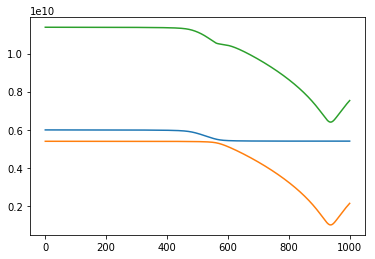

In [8]:
plt.plot(eigenstate100)
plt.plot(eigenstate001)
plt.plot(eigenstate101)
Spline100  = get_Bsline( flux_scan[:-1],(eigenstate100[1:]-eigenstate100[0:-1])/(flux_scan[1]-flux_scan[0]) )
Spline001  = get_Bsline( flux_scan[:-1],(eigenstate001[1:]-eigenstate001[0:-1])/(flux_scan[1]-flux_scan[0]) )
Spline101  = get_Bsline( flux_scan[:-1],(eigenstate101[1:]-eigenstate101[0:-1])/(flux_scan[1]-flux_scan[0]) )

In [9]:
def Gassian_distri(sigma,p):
    return np.exp( -p**2/(2*sigma**2) )/np.sqrt(2*np.pi)/sigma

In [39]:
Pulse_params_arr = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Pulse_params_arr.txt' )
# np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\RB_error_arr.txt' )
# np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Unitary_error_arr.txt' )
gate_time_arr = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\gate_time_arr.txt' )

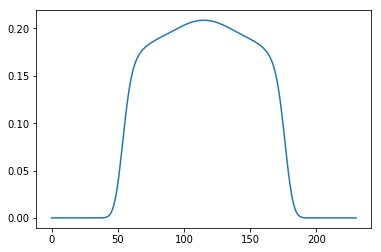

In [40]:
lamb1 = Pulse_params_arr[1]
gate_time = gate_time_arr[1]
total_len = gate_time + 10e-9

Seq=PG.Sequence(total_len=total_len,sample_rate=10e9,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),qubit=transmon,Q1_freq=6.0e9,
             CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
             anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=7.87e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [17]:
# sigma=100e-6

# phase_square_ave100 = 0
# phase_square_ave001 = 0
# phase_square_ave101 = 0
# phase_square_ave_101_001 = 0
# phase_square_ave_101_100 = 0
# phase_square_ave_100_001 = 0
# flux_noise_arr = np.linspace(-10*sigma,10*sigma,1001)
# for d_flux in flux_noise_arr:
#     d_phase100 = np.sum( get_interpolate_value(Spline100,(flux_pulse[41:-40]))*d_flux*0.1e-9)
#     phase_square_ave100 += d_phase100**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
    
#     d_phase001 = np.sum( get_interpolate_value(Spline001,(flux_pulse[41:-40]))*d_flux*0.1e-9)
#     phase_square_ave001 += d_phase001**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
    
#     d_phase101 = np.sum( get_interpolate_value(Spline101,(flux_pulse[41:-40]))*d_flux*0.1e-9)
#     phase_square_ave101 += d_phase101**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
    

#     phase_square_ave_101_001 += d_phase101*d_phase001*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
    
#     phase_square_ave_101_100 += d_phase101*d_phase100*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
    
#     phase_square_ave_100_001 += d_phase100*d_phase001*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])

## loop

In [42]:
len(gate_time_arr)

49

In [46]:
sigma=50e-6
Phase_error_arr=[]
for ii in range(49):
    print(ii)
    lamb1 = Pulse_params_arr[ii]
    gate_time = gate_time_arr[ii]
    total_len = gate_time + 10e-9
    Seq=PG.Sequence(total_len=total_len,sample_rate=10e9,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),qubit=transmon,Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
                 anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=1,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()

    phase_square_ave100 = 0
    phase_square_ave001 = 0
    phase_square_ave101 = 0
    phase_square_ave_101_001 = 0
    phase_square_ave_101_100 = 0
    phase_square_ave_100_001 = 0
    flux_noise_arr = np.linspace(-10*sigma,10*sigma,1001)
    for d_flux in flux_noise_arr:
        d_phase100 = np.sum(2*np.pi* get_interpolate_value(Spline100,(flux_pulse[41:-40]))*d_flux*0.1e-9)
        phase_square_ave100 += d_phase100**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        d_phase001 = np.sum(2*np.pi* get_interpolate_value(Spline001,(flux_pulse[41:-40]))*d_flux*0.1e-9)
        phase_square_ave001 += d_phase001**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        d_phase101 = np.sum(2*np.pi* get_interpolate_value(Spline101,(flux_pulse[41:-40]))*d_flux*0.1e-9)
        phase_square_ave101 += d_phase101**2*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        phase_square_ave_101_001 += d_phase101*d_phase001*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        phase_square_ave_101_100 += d_phase101*d_phase100*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        phase_square_ave_100_001 += d_phase100*d_phase001*Gassian_distri(sigma,d_flux)* (flux_noise_arr[1]-flux_noise_arr[0])
        
    phase_sum = 3*(phase_square_ave001+phase_square_ave101+phase_square_ave001)-2*(phase_square_ave_101_001+phase_square_ave_101_100+phase_square_ave_100_001)
    Phase_error_arr.append(phase_sum/20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


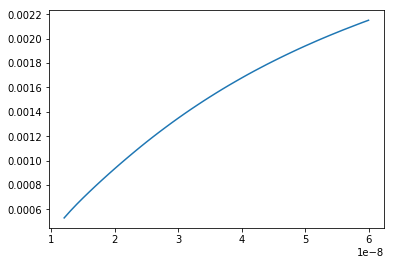

In [48]:
plt.plot(gate_time_arr,np.array(Phase_error_arr)*4 )

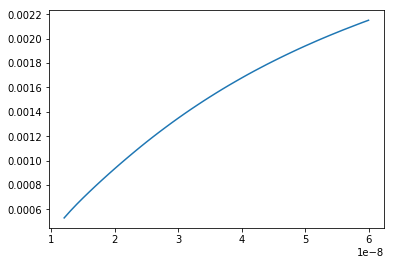

In [44]:
plt.plot(gate_time_arr,np.array(Phase_error_arr) )

In [156]:
np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Dephasing_error_sigma100u.txt',Phase_error_arr)

In [148]:
(2*np.pi)**2

39.47841760435743

In [142]:
Phase_error_arr[-1]

5.4410200639495865e-05

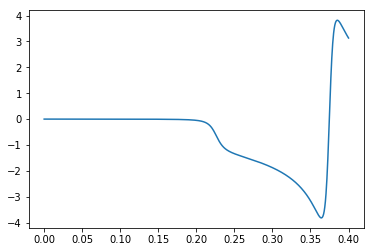

In [141]:
plt.plot(flux_scan, get_interpolate_value(Spline001,flux_scan)*sigma/np.sqrt(2)/1e6 )

In [ ]:
0.1e6

In [ ]:
(50e-9*10e3)